In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Create data

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

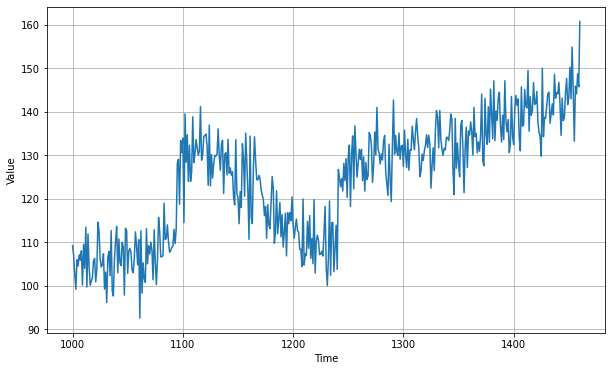

In [3]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)


# Dataset

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  '''Takes a numpy array as a serie and creates dataset'''
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

#Model

In [9]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

#Model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

#In order to search the best learning rate we create a lr schedule
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

#Model training
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

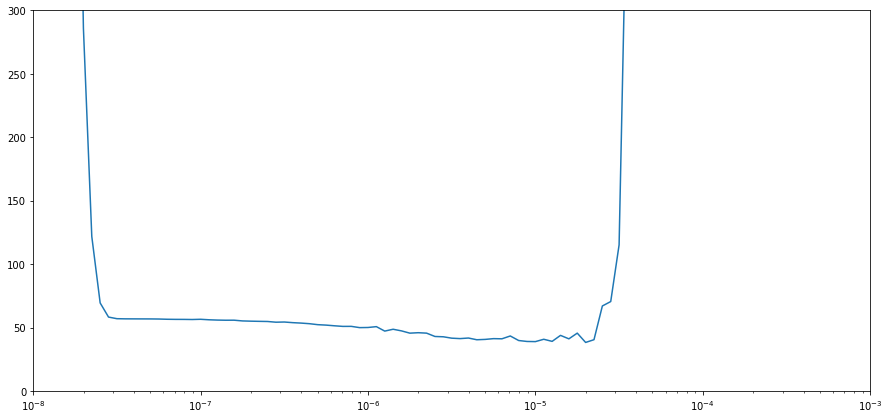

In [11]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.figure(figsize=(15,7))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])
plt.show()

In [20]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

#Same model with the best LR that we saw in the previous plot
optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

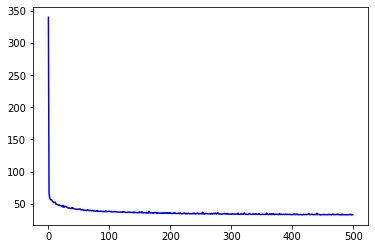

In [21]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[52.621158599853516, 52.50471496582031, 49.930023193359375, 49.0165901184082, 49.306922912597656, 48.445743560791016, 48.111698150634766, 47.49513626098633, 48.13896560668945, 47.267356872558594, 46.8829460144043, 46.615047454833984, 46.57893371582031, 45.14732360839844, 47.40544128417969, 44.74641036987305, 44.7578239440918, 46.237571716308594, 46.13859176635742, 45.06306838989258, 45.14152526855469, 44.151084899902344, 43.418556213378906, 43.45203399658203, 43.448482513427734, 43.27474594116211, 42.95516586303711, 42.540592193603516, 42.69243240356445, 44.2088737487793, 42.59140396118164, 42.89725112915039, 42.43423843383789, 42.029457092285156, 41.76178741455078, 41.32487106323242, 41.31089401245117, 41.60429000854492, 41.560848236083984, 41.326961517333984, 41.43629837036133, 41.82248306274414, 41.896175384521484, 40.53911590576172, 40.71137237548828, 40.420867919921875, 40.9238395690918, 40.49001693725586, 39.71326446533203, 39.9676399230957, 40.093265533447266, 39.91928482055664,

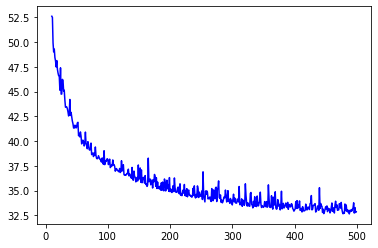

In [22]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

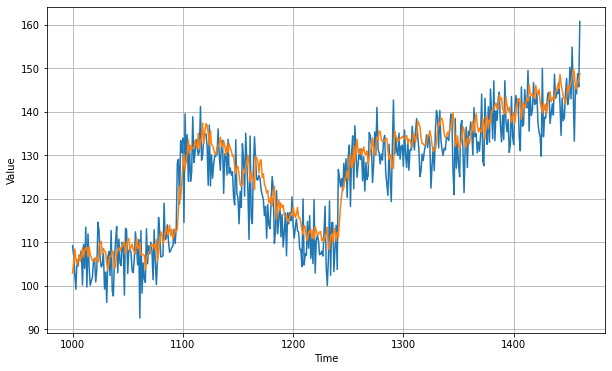

In [23]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [24]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.9168024